In [12]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# **[Project_09_Building Sentiment Classification Model_ Naver Movie Review Sentiment Analysis]**

## **1. 데이터 불러오기 및 확인**
---

### **1-1. 라이브러리 불러오기**

In [82]:
############################################## 라이브러리 불러오기 #####################################################

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format #지수표현식말고 실수로 표현
import platform
import random
import statsmodels
import math
import warnings
warnings.filterwarnings(action = "ignore")
import missingno as msno
import scipy as sp
from scipy import stats
from scipy.stats import norm
import re
import urllib.request


# 시각화
import seaborn as sns
sns.set(font_scale=1.5)
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.rcParams['axes.unicode_minus'] = False 
plt.style.use('seaborn')


# !pip install konlpy
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Mecab
from collections import Counter



# 모델
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Conv1D, GlobalMaxPooling1D, GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from konlpy.tag import Mecab


from gensim.models.keyedvectors import Word2VecKeyedVectors



### **1-2. 데이터 불러오기**

In [14]:
############################################## 데이터 불러오기 #####################################################




urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')


In [15]:

print("train_data shape: ", train_data.shape)

print(train_data.head())

train_data shape:  (150000, 3)
         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


In [16]:

print("test_data shape: ", test_data.shape)

print(test_data.head())

test_data shape:  (50000, 3)
        id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0


## **2. 데이터 탐색 및 전처리**
---

### **2-1. 데이터 로더 구성**

In [17]:
# !pip install  Mecab

In [38]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [39]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [40]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### **2-2. 데이터셋 내 문장 길이 분포 확인**

In [41]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


### **2-3. 적절한 최대 문장 길이 지정**

In [42]:

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### **2-4. Padding**

In [43]:

# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
X_train = pad_sequences(X_train,
                        value=word_to_index["<PAD>"],
                        padding='pre',
                        maxlen=maxlen)

X_test = pad_sequences(X_test,
                       value=word_to_index["<PAD>"],
                       padding='pre',
                       maxlen=maxlen)

## **3. 모델 구현**
---

## **3-1. validation set 구성**

In [46]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## **3-2. 모델 구성**

In [47]:


####################  모델 파라미터 사전 정의  #######################



vocab_size = 10000  # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원  *embedding_dim
hidden_units = 128  # 은닉 상태의 크기
dropout_ratio = 0.3 # 드롭아웃 비율
batch_size = 64
epochs = 15 

In [53]:
#################### 1) LSTM 모델 구성 #######################



lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, word_vector_dim))
lstm_model.add(Dropout(dropout_ratio))
lstm_model.add(GRU(hidden_units))
lstm_model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_lstm_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

lstm_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
lstm_model_history = lstm_model.fit(X_train, y_train, epochs=epochs, callbacks=[es, mc], batch_size=batch_size,  validation_data=(X_test, y_test))




lstm_model.summary()




Epoch 1/15
2285/2285 [==============================] - 16s 6ms/step - loss: 0.3754 - acc: 0.8309 - val_loss: 0.3435 - val_acc: 0.8482

Epoch 00001: val_acc improved from -inf to 0.84824, saving model to best_lstm_model.h5
Epoch 2/15
2285/2285 [==============================] - 14s 6ms/step - loss: 0.3155 - acc: 0.8651 - val_loss: 0.3293 - val_acc: 0.8615

Epoch 00002: val_acc improved from 0.84824 to 0.86148, saving model to best_lstm_model.h5
Epoch 3/15
2285/2285 [==============================] - 14s 6ms/step - loss: 0.2957 - acc: 0.8757 - val_loss: 0.3120 - val_acc: 0.8669

Epoch 00003: val_acc improved from 0.86148 to 0.86692, saving model to best_lstm_model.h5
Epoch 4/15
2285/2285 [==============================] - 14s 6ms/step - loss: 0.2812 - acc: 0.8826 - val_loss: 0.3039 - val_acc: 0.8702

Epoch 00004: val_acc improved from 0.86692 to 0.87017, saving model to best_lstm_model.h5
Epoch 5/15
2285/2285 [==============================] - 14s 6ms/step - loss: 0.2704 - acc: 0.8886 -

In [54]:
#################### 2) 1-D Convolution Neural Network(1-D CNN) 모델 구성 #######################


num_filters = 256
kernel_size = 3



model_conv1d = Sequential()
model_conv1d.add(Embedding(vocab_size, word_vector_dim))
model_conv1d.add(Dropout(dropout_ratio))
model_conv1d.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model_conv1d.add(GlobalMaxPooling1D())
model_conv1d.add(Dense(hidden_units, activation='relu'))
model_conv1d.add(Dropout(dropout_ratio))
model_conv1d.add(Dense(1, activation='sigmoid'))


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_conv1d.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_conv1d.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model_conv1d_history = model_conv1d.fit(X_train, y_train, epochs=epochs, callbacks=[es, mc], batch_size=batch_size,  validation_data=(X_test, y_test))



model_conv1d.summary()



Epoch 1/15
2285/2285 [==============================] - 11s 5ms/step - loss: 0.3837 - acc: 0.8269 - val_loss: 0.3410 - val_acc: 0.8548

Epoch 00001: val_acc improved from -inf to 0.85477, saving model to best_model_conv1d.h5
Epoch 2/15
2285/2285 [==============================] - 11s 5ms/step - loss: 0.3234 - acc: 0.8623 - val_loss: 0.3292 - val_acc: 0.8618

Epoch 00002: val_acc improved from 0.85477 to 0.86179, saving model to best_model_conv1d.h5
Epoch 3/15
2285/2285 [==============================] - 11s 5ms/step - loss: 0.3023 - acc: 0.8743 - val_loss: 0.3173 - val_acc: 0.8676

Epoch 00003: val_acc improved from 0.86179 to 0.86765, saving model to best_model_conv1d.h5
Epoch 4/15
2285/2285 [==============================] - 11s 5ms/step - loss: 0.2887 - acc: 0.8811 - val_loss: 0.3188 - val_acc: 0.8673

Epoch 00004: val_acc did not improve from 0.86765
Epoch 5/15
2285/2285 [==============================] - 11s 5ms/step - loss: 0.2781 - acc: 0.8860 - val_loss: 0.3105 - val_acc: 0.871

In [55]:
#################### 3) GRU 모델 구성 #######################



gru_model = Sequential()
gru_model.add(Embedding(vocab_size, word_vector_dim))
gru_model.add(GRU(hidden_units))
gru_model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_gru_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

gru_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
gru_model_history = gru_model.fit(X_train, y_train, epochs=epochs, callbacks=[es, mc], batch_size=batch_size,  validation_data=(X_test, y_test))



gru_model.summary()


Epoch 1/15
2285/2285 [==============================] - 15s 6ms/step - loss: 0.3678 - acc: 0.8357 - val_loss: 0.3391 - val_acc: 0.8528

Epoch 00001: val_acc improved from -inf to 0.85280, saving model to best_gru_model.h5
Epoch 2/15
2285/2285 [==============================] - 14s 6ms/step - loss: 0.3054 - acc: 0.8701 - val_loss: 0.3104 - val_acc: 0.8686

Epoch 00002: val_acc improved from 0.85280 to 0.86865, saving model to best_gru_model.h5
Epoch 3/15
2285/2285 [==============================] - 14s 6ms/step - loss: 0.2819 - acc: 0.8818 - val_loss: 0.3068 - val_acc: 0.8688

Epoch 00003: val_acc improved from 0.86865 to 0.86881, saving model to best_gru_model.h5
Epoch 4/15
2285/2285 [==============================] - 14s 6ms/step - loss: 0.2662 - acc: 0.8902 - val_loss: 0.2978 - val_acc: 0.8728

Epoch 00004: val_acc improved from 0.86881 to 0.87275, saving model to best_gru_model.h5
Epoch 5/15
2285/2285 [==============================] - 14s 6ms/step - loss: 0.2531 - acc: 0.8967 - val

## **3-3. 모델 평가**

In [56]:
# 모델 평가
gru_model_results = gru_model.evaluate(X_test,  y_test, verbose=2)
model_conv1d_results = model_conv1d.evaluate(X_test,  y_test, verbose=2)
lstm_model_results = lstm_model.evaluate(X_test,  y_test, verbose=2)


print("gru_model_results: ",gru_model_results)

print("model_conv1d_results: ",model_conv1d_results)

print("lstm_model_results: ",lstm_model_results)

1537/1537 - 3s - loss: 0.3072 - acc: 0.8712
1537/1537 - 2s - loss: 0.3589 - acc: 0.8558
1537/1537 - 3s - loss: 0.3074 - acc: 0.8700
gru_model_results:  [0.30723077058792114, 0.8711678981781006]
model_conv1d_results:  [0.35893818736076355, 0.8558089137077332]
lstm_model_results:  [0.30735528469085693, 0.8700083494186401]


In [61]:
gru_model_history_dict = gru_model_history.history
print("gru_model_history_dict: ",gru_model_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

model_conv1d_history_dict = model_conv1d_history.history
print("model_conv1d_history_dict: ",model_conv1d_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들


lstm_model_history_dict = lstm_model_history.history
print("lstm_model_history_dict: ",lstm_model_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

gru_model_history_dict:  dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
model_conv1d_history_dict:  dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
lstm_model_history_dict:  dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


## **3-4. Loss, Accuracy 그래프 시각화**

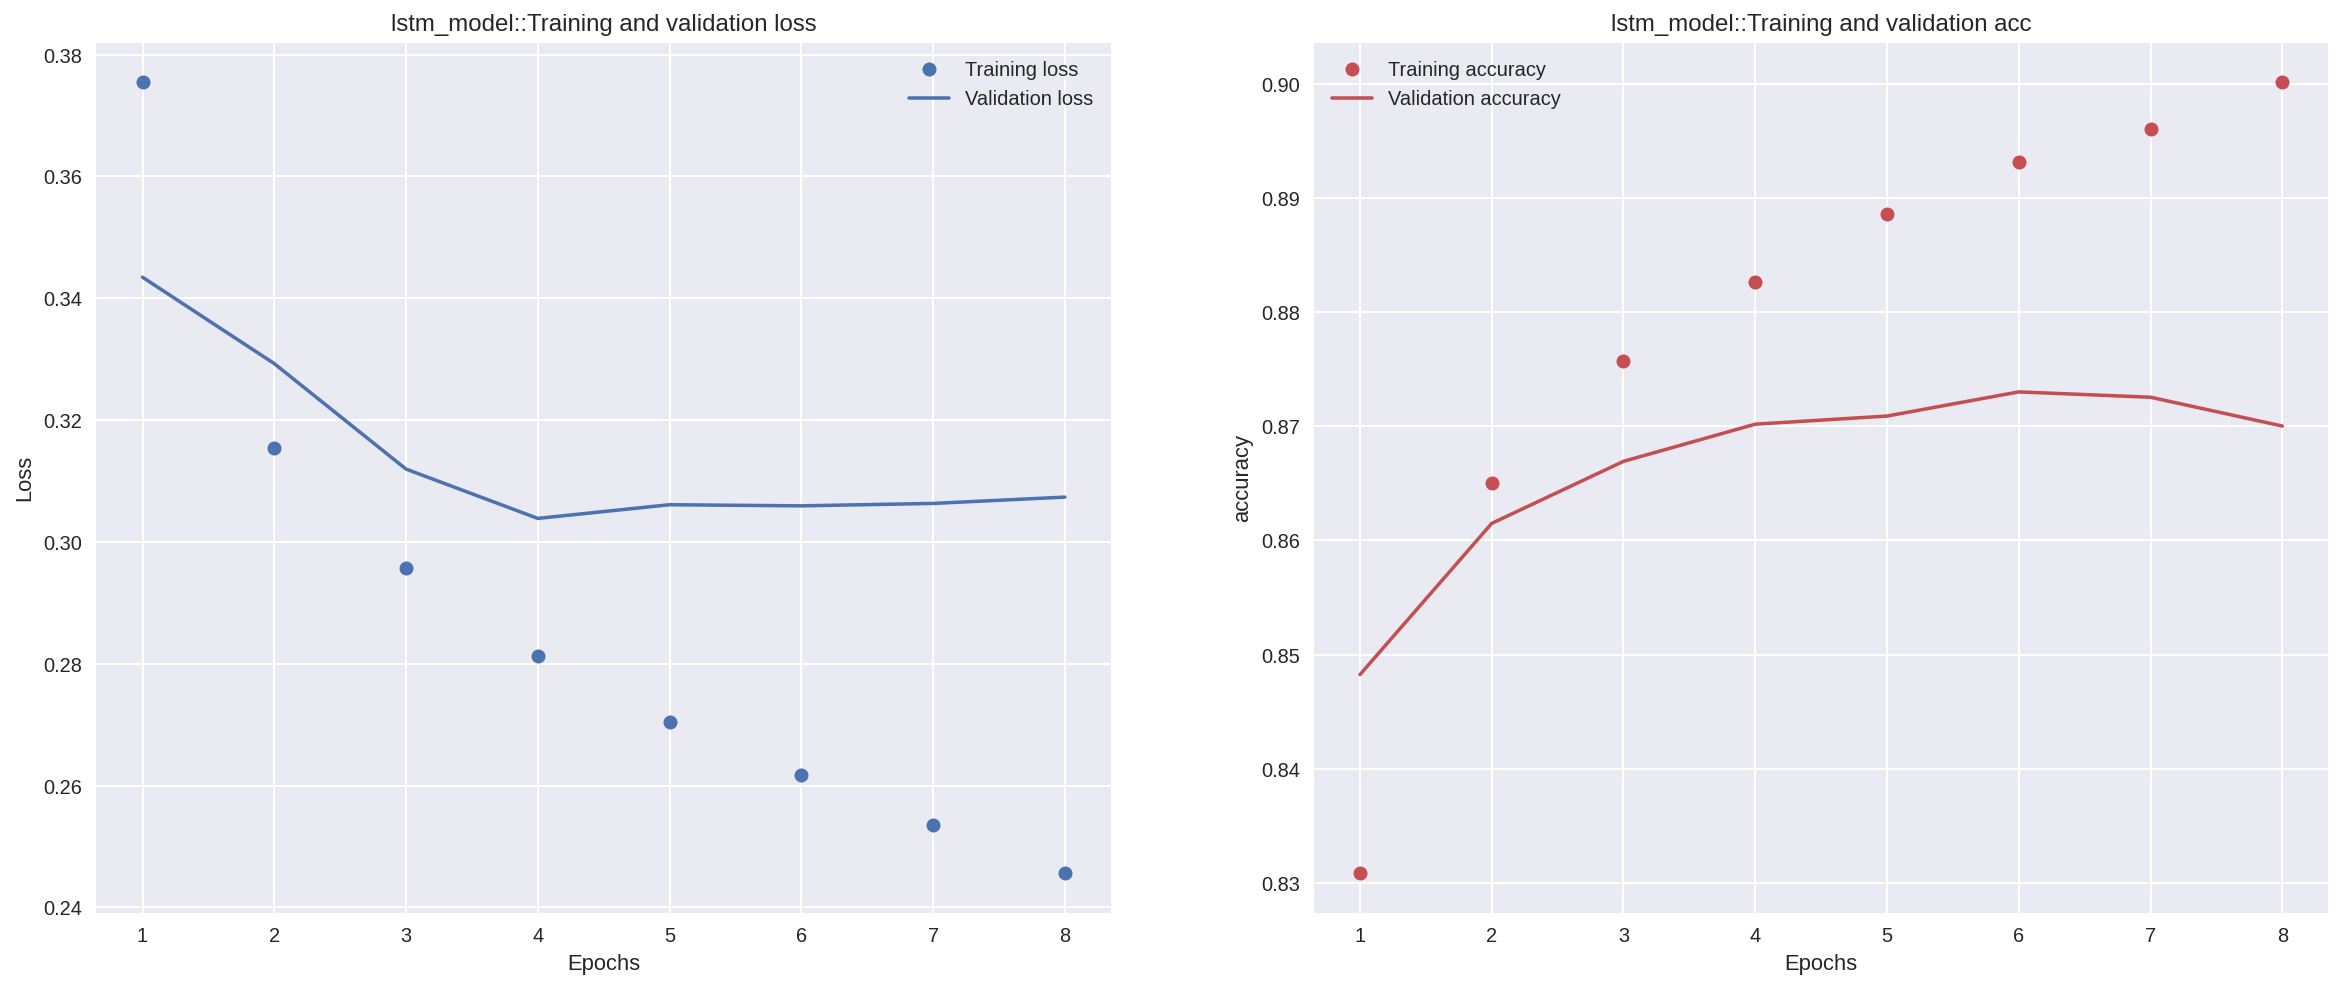

In [78]:
#################### lstm 모델 Training and validation loss #######################



lstm_model_acc = lstm_model_history_dict['acc']
lstm_model_val_acc = lstm_model_history_dict['val_acc']
lstm_model_loss = lstm_model_history_dict['loss']
lstm_model_val_loss = lstm_model_history_dict['val_loss']

lstm_model_epochs = range(1, len(lstm_model_acc) + 1)



plt.figure(figsize=(20, 8))


plt.subplot(1, 2, 1)
# "bo"는 "파란색 점"입니다
plt.plot(lstm_model_epochs, lstm_model_loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(lstm_model_epochs, lstm_model_val_loss, 'b', label='Validation loss')
plt.title('lstm_model::Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_model_epochs, lstm_model_acc, 'ro', label='Training accuracy')
# b는 "파란 실선"입니다
plt.plot(lstm_model_epochs, lstm_model_val_acc, 'r', label='Validation accuracy')
plt.title('lstm_model::Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

 

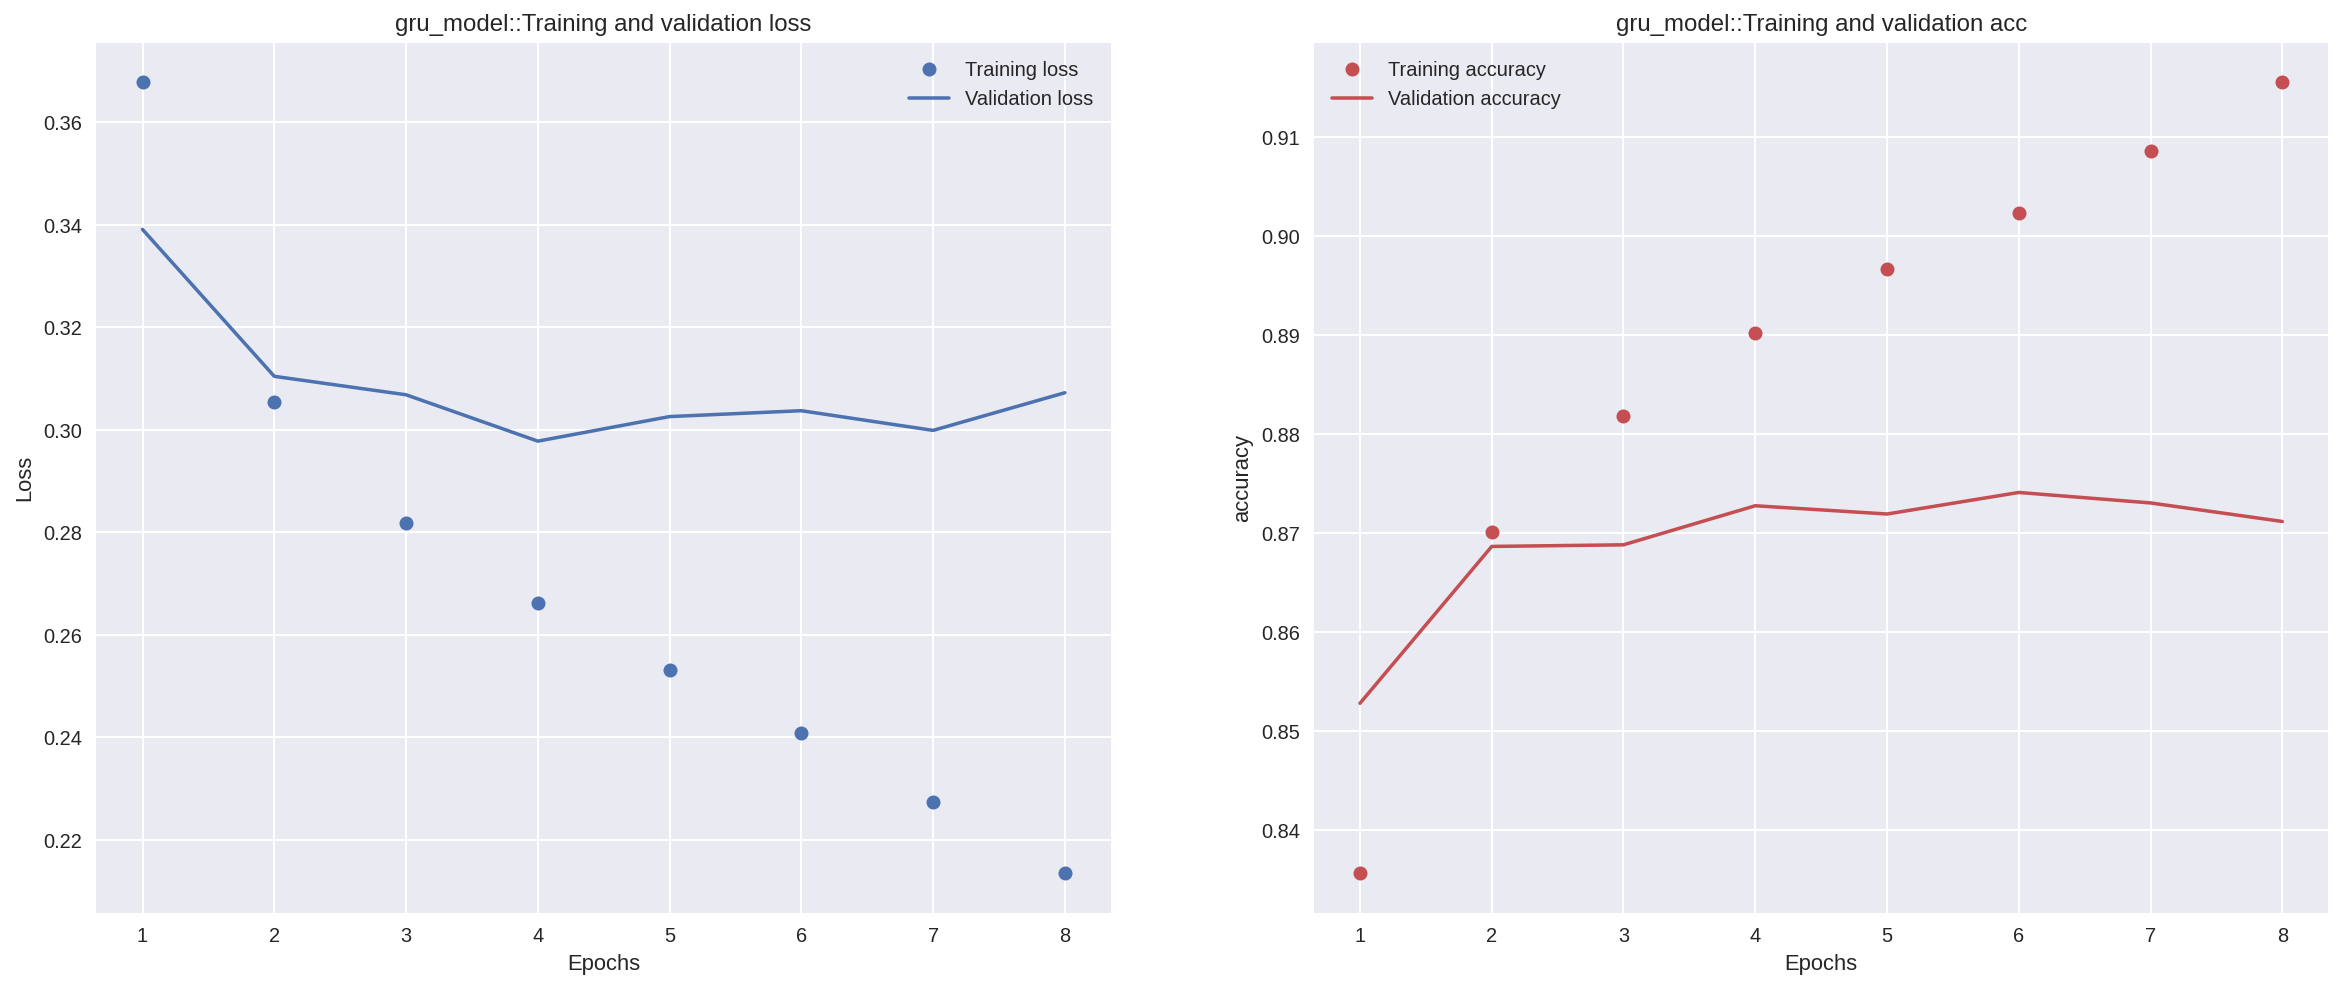

In [79]:
#################### gru 모델 Training and validation loss #######################



gru_model_acc = gru_model_history_dict['acc']
gru_model_val_acc = gru_model_history_dict['val_acc']
gru_model_loss = gru_model_history_dict['loss']
gru_model_val_loss = gru_model_history_dict['val_loss']

gru_model_epochs = range(1, len(gru_model_acc) + 1)



plt.figure(figsize=(20, 8))


plt.subplot(1, 2, 1)
# "bo"는 "파란색 점"입니다
plt.plot(gru_model_epochs, gru_model_loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(gru_model_epochs, gru_model_val_loss, 'b', label='Validation loss')
plt.title('gru_model::Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gru_model_epochs, gru_model_acc, 'ro', label='Training accuracy')
# b는 "파란 실선"입니다
plt.plot(gru_model_epochs, gru_model_val_acc, 'r', label='Validation accuracy')
plt.title('gru_model::Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

 

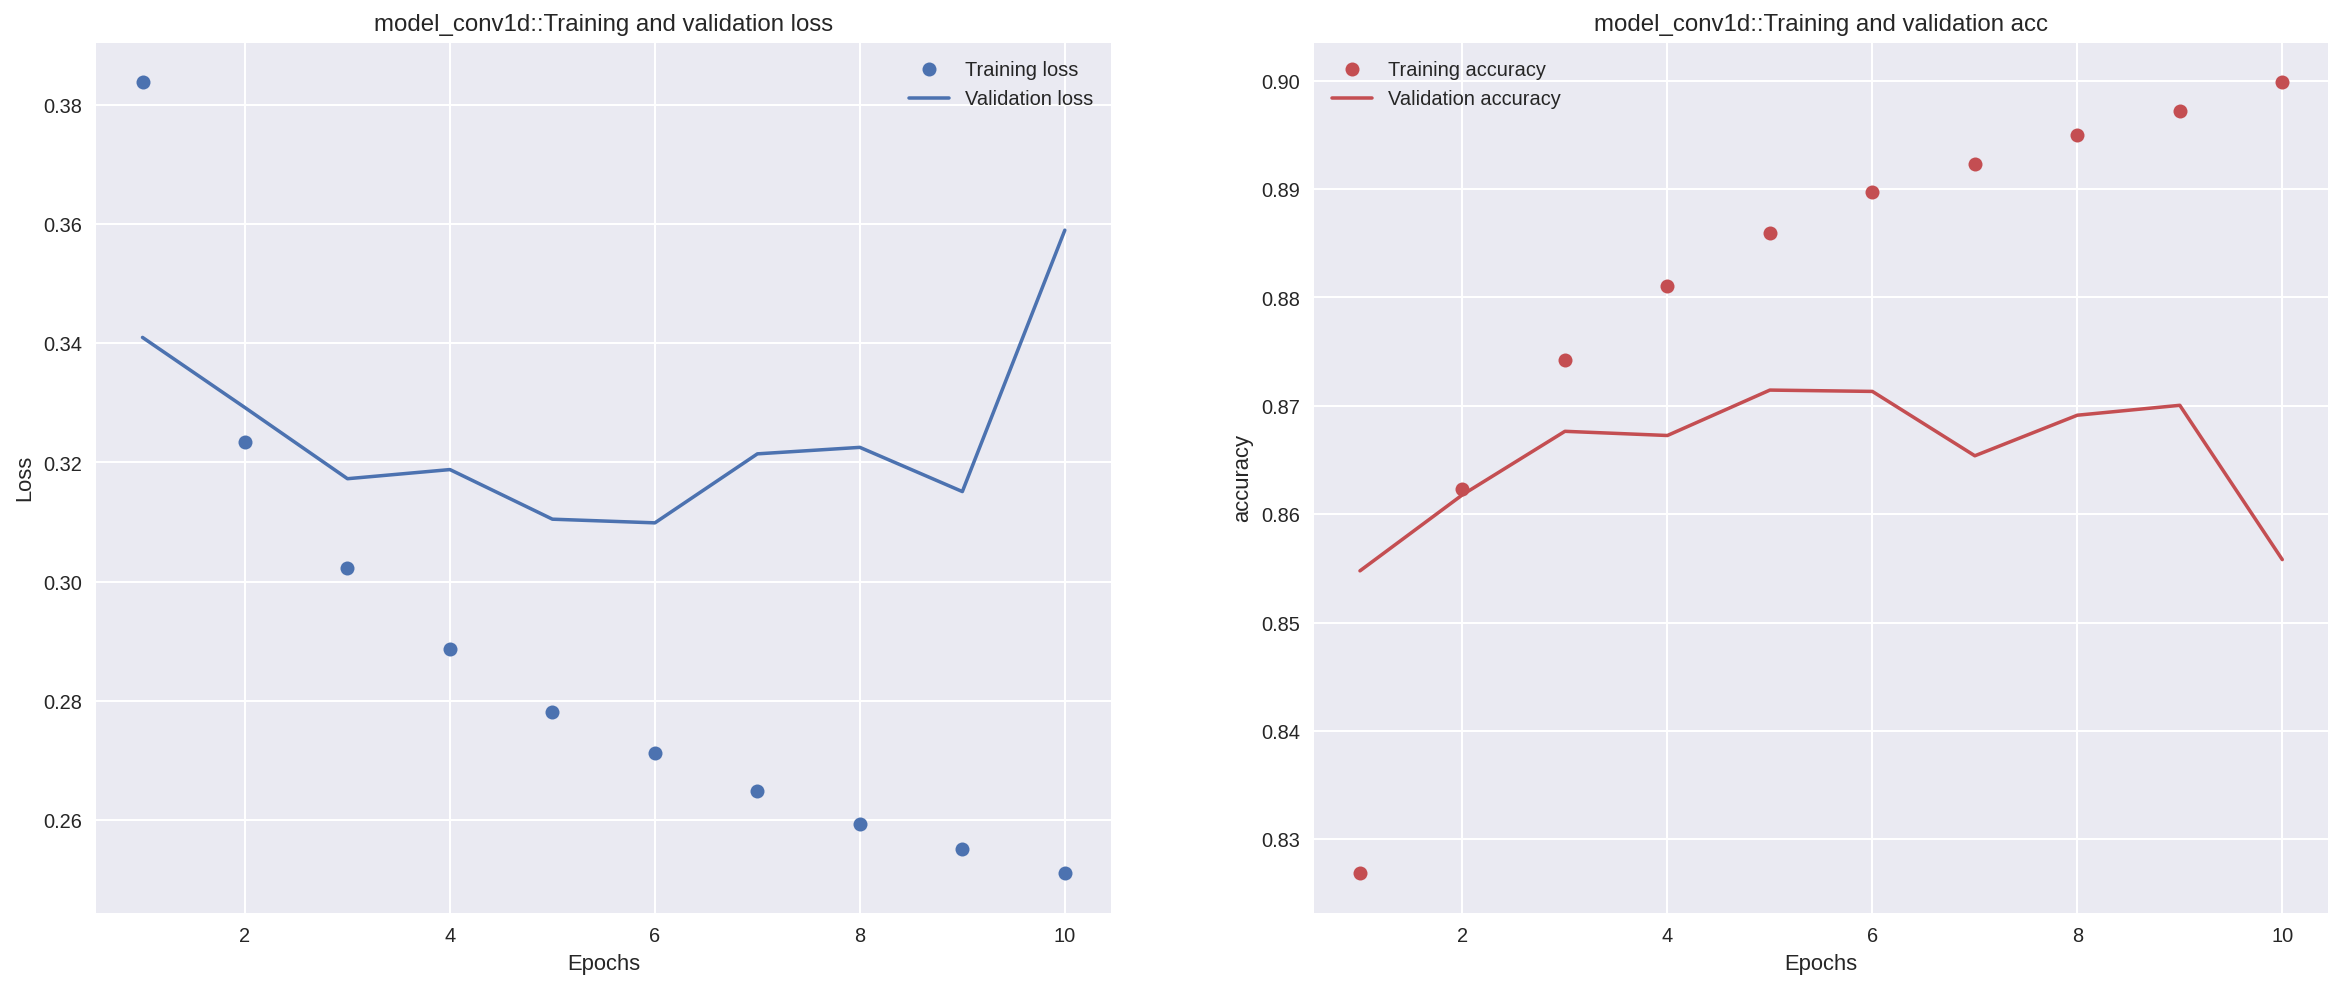

In [81]:

#################### gru 모델 Training and validation loss #######################



model_conv1d_acc = model_conv1d_history_dict['acc']
model_conv1d_val_acc = model_conv1d_history_dict['val_acc']
model_conv1d_loss = model_conv1d_history_dict['loss']
model_conv1d_val_loss = model_conv1d_history_dict['val_loss']

model_conv1d_epochs = range(1, len(model_conv1d_acc) + 1)



plt.figure(figsize=(20, 8))


plt.subplot(1, 2, 1)
# "bo"는 "파란색 점"입니다
plt.plot(model_conv1d_epochs, model_conv1d_loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(model_conv1d_epochs, model_conv1d_val_loss, 'b', label='Validation loss')
plt.title('model_conv1d::Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model_conv1d_epochs, model_conv1d_acc, 'ro', label='Training accuracy')
# b는 "파란 실선"입니다
plt.plot(model_conv1d_epochs, model_conv1d_val_acc, 'r', label='Validation accuracy')
plt.title('model_conv1d::Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()


In [87]:
model_name = f'{lstm_model}'
model_name

'<keras.engine.sequential.Sequential object at 0x7f374b3ddac0>'

## **3-5. 학습된 Embedding 레이어 분석**

In [114]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors

models = [model_conv1d, gru_model,lstm_model]
for model in models:
    if model == model_conv1d:
        print("=====================model_conv1d==========================")
        
    if model == gru_model:
        print("=====================gru_model==========================")
        
    if model == lstm_model:
        print("=====================lstm_model==========================")
        
        
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]
    print(weights.shape)    # shape: (vocab_size, embedding_dim)
    # 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
    word2vec_file_path = os.getenv('HOME')+f'/aiffel/sentiment_classification/data/word2vec_{model}.txt'
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
    vectors = model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()
    
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    vector = word_vectors['우정']
    print(vector)
    
    
    # 우정과 비슷한 단어
    print("우정과 비슷한 단어: \n", word_vectors.similar_by_word("우정"))

=====================model_conv1d==========================
(10000, 100)
[ 0.49342528 -0.06184579 -0.26014277 -0.03806143 -0.05336595  0.05573398
  0.21122047 -0.00366464  0.02282821  0.2668408   0.18030728 -0.42411348
  0.31090155  0.50655574 -0.15770519 -0.10151944 -0.32479677 -0.03034544
  0.2586667   0.01509361  0.14106649 -0.17587571 -0.27215278 -0.23222429
 -0.30425638 -0.13483362 -0.08428443 -0.16008453  0.003953    0.09160564
 -0.20701732 -0.02735716 -0.19526783  0.21181242  0.03799912  0.04610707
 -0.10218949  0.06681357 -0.22105116 -0.11257363  0.23898493 -0.04771948
  0.04700214 -0.38470483 -0.0041948  -0.2230802   0.26098797 -0.14353849
 -0.05052116  0.00854348  0.19862045  0.09609646  0.04244021 -0.31842157
 -0.01654394 -0.08916096 -0.23974617  0.02112144 -0.10514814  0.05452031
  0.09957391  0.20792687  0.41814506  0.01413834  0.03651652  0.15294345
  0.11897662 -0.36918253  0.40618804  0.08971304  0.23736857  0.02218907
 -0.07578679  0.08045951 -0.3049521   0.27998117  0

## **3-6. 한국어 Word2Vec 임베딩 활용하여 성능 개선**

In [152]:
!pip install konlpy==0.4.4 
!pip install gensim==3.8.3

In [155]:
# 한국어 Word2Vec 임베딩 활용한 성능 개선

import gensim
from gensim.test.utils import common_texts
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors





word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

vector = word2vec['우정']
print(vector)     


AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.9/site-packages/gensim/models/word2vec.py'>

In [156]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("친구")

AttributeError: module 'gensim.models.word2vec' has no attribute 'similar_by_word'

In [104]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

In [ ]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

In [ ]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)